# Homework 2: Hunt the Wampa

Written by Lara J. Martin at the
University of Maryland, Baltimore County

(Star Wars theming courtesy of Chris Callison-Burch)

Assignment questions can be found here: [https://laramartin.net/Principles-of-AI/homeworks/logic/logical-agent.html](https://laramartin.net/Principles-of-AI/homeworks/logic/logical-agent.html)

## Introduction
*Help! Luke has gotten stuck in an ice cave and is about to be eaten by a Wampa! Can R2-D2 save him in time?!*
https://www.youtube.com/watch?v=8JWiKVDfRxQ
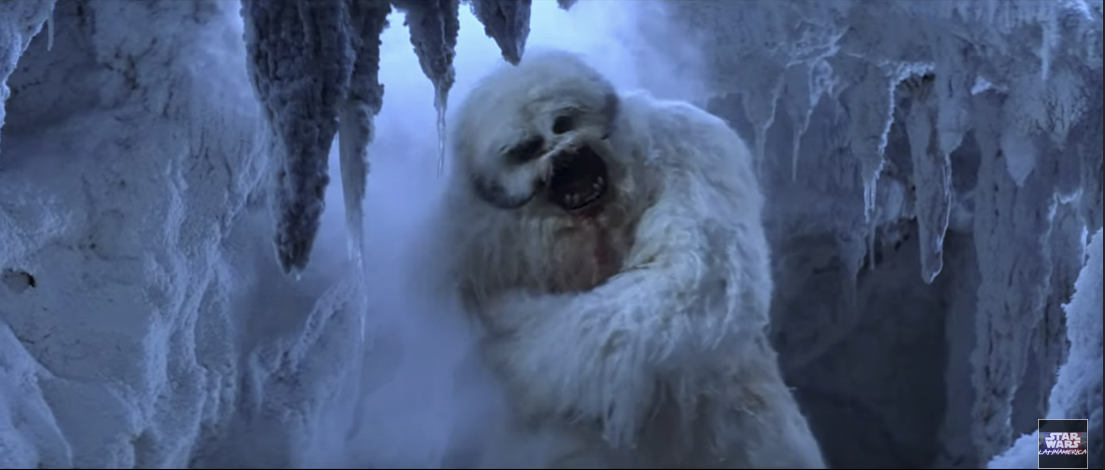

In this assignment, you will be creating a logical agent inside of Wampa World (the Star Wars reskinning of Wumpus World). The environment has been coded for you; you're just focusing on the agent.

Read section 7.7 of the AI textbook for more information on making propositional logic agents.


## Rules of Wampa World
The goal of the game is to pick up Luke, bring him out of the cave, and don't get hurt by the Wampa or any of the bottomless pits throughout the cave.

There is 1 Wampa and several pits distributed on a single map. The Wampa will eat anything that enters its room and the pits will trap any agents.

### Wampa World Scoring:
*   +1000 points for Grabbing Luke and Climbing out of the cave
* -1000 for falling into a pit or being eaten by a Wampa
* -1 for each action taken
* -10 for using up your 1 blaster fire

### Possible actions (each cost 10 in-game points):
*   `Forward` - move 1 room forward in whatever direction R2 is facing
*   `TurnLeft` - rotate to the left
* `TurnRight` - rotate to the right
* `Shoot` - fire a single (one) blaster bolt in a straight line in whatever direction R2 is facing
* `Grab` - pick up Luke when you are in his room
* `Climb` - leave the cave when you have picked up Luke and are back to room [1,1]

You call these actions through the command
`
w.action(Forward)
`
where *w* is your WampaWorld() instance variable, and the argument is one of the six above action variables.

Every time you do an action, it returns 3 things:
1. True/False depending on whether or not the action was successful done.

    * **Note: In the case of shooting his blaster, this does not mean that the shot hit the Wampa but simply that the blaster was shot successfully. There are other ways to figure out if the Wampa was hit...**
2. The current [x,y] location of the agent.
3. A string or other information that tells you (the coder) about what happened. If R2 was going Forward, it will give you a list of percepts for the new room.


### R2's Sensors:
There are a number of different things that R2-D2 has sensors for. His sensors pick up important percepts that help him navigate the world and get stuff done.
* He has an olfactory sensor to pick up _stenches_. Wampas are very stinky and sensing stenches helps R2 figure out that a Wampa might be in the next room. Wampas will emanate a _stench_ to every room directly next door.
* He has a pressure sensor in his antennae that tells him if there's a _breeze_ nearby. Pits make strange air currents, so every room next to a pit will have a _breeze_.
* He has a microphone that is listening hard for Luke. R2 can use his microphone to pick up if anyone _gasps_ for air and might be in trouble.
* He has bumpers that are pressure-sensitive for if he _bumps_ into any walls in the cave since his cameras aren't always that good, especially in dark caves.
* He also has his microphone set for high-frequency noises such as _screams_. R2 knows that if the Wampa is killed, it will let out a hugh _scream_ that will echo all throughout the cave.

### Bonus Commands:
You are also allowed to get the following information about the environment for free (no in-game points lost).

*   `w.getPercepts()` - get R2-D2's list of percepts in the form [Stench, Breeze, Gasp, Bump, Scream]
*   `w.getLocation()` - get R2-D2's [x,y] coordinates (**Note: R2-D2 starts in [1,1].**)
*   `w.getDirection()` - find out whether R2-D2 is facing up, down, left, or right (**Note: R2-D2 starts out facing to the right.**)
*   `w.getScore()` - get the current score (returns an integer)
*   `w.getBlaster()` - get whether or not you have your shot still (returns a boolean)






## Environment
Do not edit this code.

In [ ]:
from google.colab import files
import json
from math import modf

In [ ]:
def fitGrid(grid, item):
  grid_x, grid_y = grid
  x, y = item
  loc = []

  if x < grid_x:
    loc += [[x+1,y]]
  if x > 1:
    loc += [[x-1,y]]
  if y < grid_y:
    loc += [[x,y+1]]
  if y > 1:
    loc += [[x,y-1]]

  return loc

Forward = "forward"
TurnLeft = "left"
TurnRight = "right"
Shoot = "shoot"
Grab = "grab"
Climb = "climb"

class WampaWorld:
  def __init__(self, worldInit):
    # uploaded = files.upload()
    # initFile = list(uploaded.keys())[0]
    # with open(initFile, 'r') as file:
    #     worldInit = json.load(file)

    #worldInit['grid'] - size of the grid
    #worldInit['wampa'] - location of wampa
    #worldInit['pits'] - location of pits
    #worldInit['luke'] - location of Luke
    self.gridsize = worldInit['grid']
    self.wampa = worldInit['wampa']
    self.pits = worldInit['pits']
    self.luke = worldInit['luke']
    self.wampaAlive = True


    #populate grid with breezes
    breeze = []
    for pit in worldInit['pits']:
      breeze += fitGrid(worldInit['grid'], pit)

    #prepopulate grid with percepts
    stench=fitGrid(worldInit['grid'], self.wampa)
    self.grid = [[set() for y in range(worldInit['grid'][1])] for x in range(worldInit['grid'][0])]
    for x in range(1,worldInit['grid'][0]+1):
      for y in range(1,worldInit['grid'][1]+1):
        percepts = [None, None, None, None, None]
        if [x,y] in stench: percepts[0] = "stench"
        if [x,y] in breeze: percepts[1] = "breeze"
        self.grid[x-1][y-1] = percepts
    self.grid[self.luke[0]-1][self.luke[1]-1][2] = "gasp"

    self.agent = Agent()

  def getPercepts(self):
    x,y = self.agent.loc
    return self.grid[x][y]

  def checkBlasterHits(self):
    #DO NOT CALL OR YOU WILL LOSE 5 POINTS ON THE ASSIGNMENT
    dir = self.getDirection()
    x, y = self.agent.loc
    x+=1
    y+=1
    hit = False
    if (dir == "up" and self.wampa[1] > y and self.wampa[0] == x) or \
       (dir == "down" and self.wampa[1] < y and self.wampa[0] == x) or \
       (dir == "left" and self.wampa[0] < x and self.wampa[1] == y) or \
       (dir == "right" and self.wampa[0] > x and self.wampa[1] == y):
       hit = True
       self.wampaAlive = False
    if hit:
      for x in range(len(self.grid)):
        for y in range(len(self.grid[0])):
          self.grid[x][y][4]="scream"
          self.grid[x][y][0]=None
    return hit

  def action(self,action):
    x,y = self.agent.loc
    self.agent.score-=1


    #R2 moves forward from whatever direction he's facing
    if action == Forward:
      moved = True
      orientation = self.getDirection()
      if orientation == "up":
        if y < len(self.grid[0])-1:
          self.agent.loc = [x,y+1]
        else:
          moved = False
      elif orientation == "down":
        if y > 0:
          self.agent.loc = [x,y-1]
        else:
          moved = False
      elif orientation == "left":
        if x > 0:
          self.agent.loc = [x-1,y]
        else:
          moved = False
      elif orientation == "right":
        if x < len(self.grid)-1:
          self.agent.loc = [x+1,y]
        else:
          moved = False
      if (self.getLocation() == self.wampa and self.wampaAlive) or self.getLocation() in self.pits:
        self.agent.score -= 1000
        print("R2-D2 has been crushed, -1000 points")
        print("Your final score is: ", self.agent.score)
        quit()
      if moved == False:
        percepts = self.getPercepts()
        percepts[3] = "bump"
        return False, self.getLocation(), percepts
      else: return True, self.getLocation(), self.getPercepts()

    #R2 turns left
    elif action == TurnLeft:
      self.agent.turnLeft()
      return True, self.getLocation(), self.getDirection()

    #R2 turns right
    elif action == TurnRight:
      self.agent.turnRight()
      return True, self.getLocation(), self.getDirection()

    #R2 fires his blaster
    elif action == Shoot:
      blaster = self.getBlaster()
      if blaster:
        self.agent.blaster = False
        hits = self.checkBlasterHits()
        return True, self.getLocation(), "Blaster bolt was shot"
      return False, self.getLocation(), "No blaster bolts available"


    #R2 grabs Luke
    elif action == Grab:
      if self.getLocation() == self.luke and not self.agent.hasLuke:
        self.agent.hasLuke = True
        return True, self.getLocation(), "R2-D2 has picked up Luke"
      elif self.agent.hasLuke:
        return False, self.getLocation(), "R2 already has Luke"
      else:
        return False, self.getLocation(), "R2 cannot pick up Luke here"


    #R2 climbs out
    elif action == Climb:
      if self.agent.hasLuke and self.agent.loc == [0,0]:
        self.agent.score += 1000
        return True, self.getLocation(), "Congrats! R2 has saved Luke! +1000 points! Your final score: "+str(self.agent.score)
      else:
        return False, self.getLocation(), "Climb requirements are not met yet"

    else:
      raise ValueError("R2-D2 can only move Forward, TurnLeft, TurnRight, Shoot, Grab, or Climb.")




  def useBlaster(self):
    self.agent.blaster = False
    self.agent.score-=10


  def getScore(self):
    return self.agent.score
  def getLocation(self):
    x,y = self.agent.loc
    return [x+1,y+1]
  def getBlaster(self):
    return self.agent.blaster
  def getDirection(self):
    #orientation
    amount = float(self.agent.degrees) / 360
    fraction, _ = modf(amount)
    match fraction:
      case 0:
        orientation= "up"
      case .25:
        orientation= "right"
      case .5:
        orientation= "down"
      case .75:
        orientation= "left"
    return orientation


## Running the game




### Scenarios
**Do not change these.**

In [ ]:
w1 = {
    "grid":[4,4],
    "wampa":[2,1],
    "pits":[[2,2],[1,4]],
    "luke":[3,4]
}

w2 = {
    "grid":[4,4],
    "wampa":[1,3],
    "pits": [[3,1],[3,3],[4,4]],
    "luke": [2,3]
}
w3 = {
    "grid":[5,5],
    "wampa":[4,4],
    "pits": [[1,5],[2,3],[5,1],[5,5],[3,2]],
    "luke": [2,5]
}

w4 = {
    "grid":[6,6],
    "wampa":[4,1],
    "pits":[[1,2],[2,2],[1,6],[5,3],[6,1],[6,3],[3,4],[4,4]],
    "luke":[5,4]
}

w5 = {
    "grid":[3,4],
    "wampa":[3,3],
    "pits":[[2,2],[2,4]],
    "luke":[3,4]
}

### Agent

Below is the Agent code that you will be implementing. In the Agent class, you will implement:
 * `knowledgeBaseQuery()` to
 * `knowledgeBaseStore()`
 * `inferenceAlgorithm()` to perform inferences
 * Initialize the class with the knowledge base and anything else you might need to get the agent to work
 * You are also welcome to create new functions to aid in the actual movement of the agent. (Or you can put the movement in the code under "Run the Agent".)

#### Important: You are welcome to break out of standard propositional logic notation by creating more general sentences and treating the coordinates as integers instead of part of the name of the variable. For example, B11 ⇔ (P12 ⋁ P21 ) could become B[x][y] ⇔ ( P[x][y+1] ⋁ P[x+1][y] ).

In [ ]:
class Agent:
  def __init__(self):
    # Do not change these variables
    self.loc = [0,0]
    self.blaster = True
    self.score = 0
    self.degrees = 90
    self.hasLuke = False

    #### YOUR CODE HERE ####
    # Initialize anything the agent needs up here.
    KB = {} # You can make this any data structure that makes sense to you
    # You can initialize your KB with some of the rules that we talked about in class:
    # ¬ P11
    # B11 ⇔ (P12 ⋁ P21 )
    # B21 ⇔ (P11 ⋁ P22 ⋁ P31 )
    # You will need to initialize your KB more by turning all the rules of the game into propositional logic


  ###################
  def turnLeft(self):
    self.degrees -= 90

  def turnRight(self):
    self.degrees += 90
  ####################

  def knowledgeBaseQuery(self):
    #### YOUR CODE HERE ####
    # This function is for picking out relevant information to do deductions/inferences

    return


  def knowledgeBaseStore(self):
    #### YOUR CODE HERE ####
    # This function is for storing new inferences in your KB

    return


  def inferenceAlgorithm(self):
    #### YOUR CODE HERE ####
    # This is where you do your inferences on the facts about the world and what you have already stored in your KB
    # Refer to the slides for sound rules of inference and rules of equivalence
    return

### Run the agent

Call `w.agent.inferenceAlgorithm()` & `w.agent.knowledgeBaseQuery()` to use their information to move your agent around the world. Use `w.agent.knowledgeBaseStore()` to store new inferences in your KB.

In [ ]:
#### YOUR CODE HERE ####
w = WampaWorld(w1) #load the scenario

# command the agent
print(w.getLocation())
print(w.getPercepts())
print(w.action(TurnLeft))
print(w.action(Forward)) #Forward, TurnLeft, TurnRight, Shoot, Grab, or Climb


[1, 1]
['stench', None, None, None, None]
(True, [1, 1], 'up')
(True, [1, 2], [None, 'breeze', None, None, None])
